In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Load file
file_path = "./retail.xlsx"
df = pd.read_excel(file_path)

In [12]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
df.drop_duplicates(inplace=True)
df = df.dropna()

In [14]:
# Summary statstics of qualitative variables
df.drop(columns=['InvoiceNo', 'StockCode']).describe(include='object').T

,count,unique,top,freq
Description,401604,3896,WHITE HANGING HEART T-LIGHT HOLDER,2058
Country,401604,37,United Kingdom,356728


In [15]:
# Summary statstics of quantitative variables
df.drop(columns=['InvoiceDate', 'CustomerID']).describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,401604.0,12.183273,250.283037,-80995.0,2.00,5.00,12.00,80995.0
UnitPrice,401604.0,3.474064,69.764035,0.0,1.25,1.95,3.75,38970.0


In [16]:
# Count unique Occurences
num_unique_customers = df["CustomerID"].nunique()
num_unique_countries = df["Country"].nunique()
num_unique_products= df["StockCode"].nunique()
num_unique_transactions= df["InvoiceNo"].nunique()

# Print results
print(f"Number of entries: {df.shape[0]}")
print(f"Number of unique Customer IDs: {num_unique_customers}")
print(f"Number of unique Countries: {num_unique_countries}")
print(f"Number of unique Products: {num_unique_products}")
print(f"Number of unique Transactions: {num_unique_transactions}")

Number of entries: 401604
Number of unique Customer IDs: 4372
Number of unique Countries: 37
Number of unique Products: 3684
Number of unique Transactions: 22190


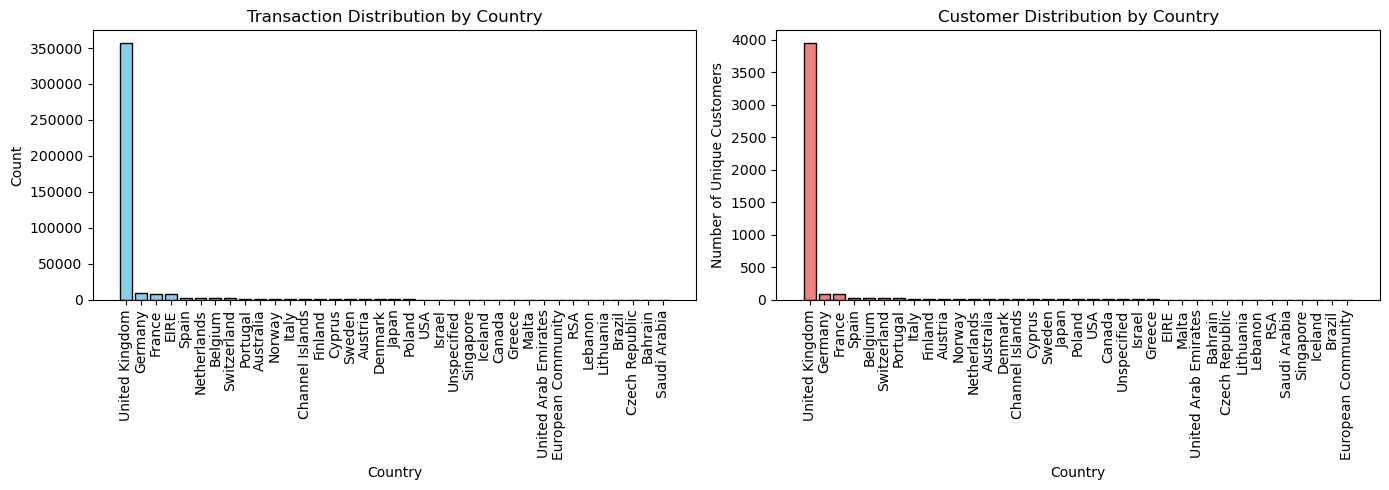

In [17]:
# EDA on countries

# Create parent figure
plt.figure(figsize=(14, 5))  

# Count occurrences of each country by transaction
country_counts = df["Country"].value_counts()
plt.subplot(1, 2, 1) 
plt.bar(country_counts.index, country_counts.values, color="skyblue", edgecolor="black")
plt.xticks(rotation=90) 
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Transaction Distribution by Country")

# Count the number of unique customers per country
customers_per_country = df.groupby("Country")["CustomerID"].nunique().sort_values(ascending=False)
plt.subplot(1, 2, 2) 
plt.bar(customers_per_country.index, customers_per_country.values, color="lightcoral", edgecolor="black")
plt.xticks(rotation=90)
plt.xlabel("Country")
plt.ylabel("Number of Unique Customers")
plt.title("Customer Distribution by Country")

plt.tight_layout()  
plt.show()

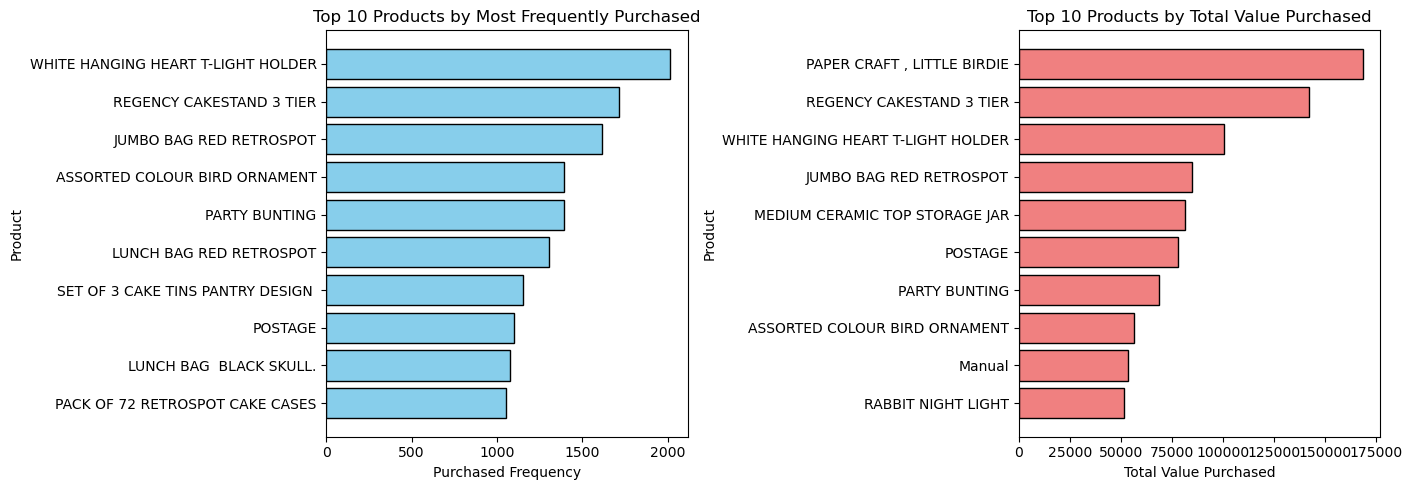

In [18]:
# EDA on products

# Create parent figure
plt.figure(figsize=(14, 5)) 

# Remove canceled products and create monetary columns to record the total value
df.loc[:, "Monetary"] = df["Quantity"] * df["UnitPrice"]
success_df = df[~df["InvoiceNo"].astype(str).str.startswith('C')]

# Plot the top 10 most purchased products
top_products = success_df["Description"].value_counts().head(10)

plt.subplot(1, 2, 1) 
plt.barh(top_products.index.astype(str), top_products.values, edgecolor='black', color='skyblue')
plt.xlabel("Purchased Frequency")
plt.ylabel("Product")
plt.title("Top 10 Products by Most Frequently Purchased")
plt.gca().invert_yaxis()

# Plot the top 10 most purchased products based on total value purchased
product_sales = success_df.groupby("Description")["Monetary"].sum()
top_products_value = product_sales.nlargest(10)
plt.subplot(1, 2, 2) 
plt.barh(top_products_value.index.astype(str), top_products_value.values, color='lightcoral', edgecolor='black')
plt.xlabel("Total Value Purchased")
plt.ylabel("Product")
plt.title("Top 10 Products by Total Value Purchased")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# EDA on canceled products

# Create parent figure
plt.figure(figsize=(14, 5)) 
canceled_items = df[df["InvoiceNo"].astype(str).str.startswith('C')]

# Plot the top 10 most purchased products
top_canceled_items = canceled_items["Description"].value_counts().head(10)
plt.subplot(1, 2, 1) 
plt.barh(top_canceled_items.index.astype(str), top_canceled_items.values, edgecolor='black', color='skyblue')
plt.xlabel("Purchased Frequency")
plt.ylabel("Product")
plt.title("Top 10 Most Frequently canceled products")
plt.gca().invert_yaxis()

# Plot the top 10 most purchased products based on total value purchased

product_sales = canceled_items.groupby("Description")["Monetary"].sum().abs()
top_products_value = product_sales.nlargest(10)
plt.subplot(1, 2, 2) 
plt.barh(top_products_value.index.astype(str), top_products_value.values, color='lightcoral', edgecolor='black')
plt.xlabel("Total Value Purchased")
plt.ylabel("Product")
plt.title("Top 10 Products by Total Value Canceled")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [19]:
# Create RFM Indexes and calculate cancellation rate for each customer

reference_date = df["InvoiceDate"].max()

# Compute RFM by creating a new df that groups by customer ID
rfm_df = df.groupby("CustomerID").agg(
    LastPurchaseDate=("InvoiceDate", "max"), 
    Frequency=("InvoiceNo", "nunique"), 
    Monetary=("Monetary", "sum") 
)
rfm_df["Recency"] = (reference_date - rfm_df["LastPurchaseDate"]).dt.days

# Compute cancellation percentage for each customer
df.loc[:, "Cancelled"] = df["InvoiceNo"].astype(str).str.startswith('C')
cancelled_percentage = df.groupby("CustomerID")["Cancelled"].mean() * 100
rfm_df = rfm_df.merge(cancelled_percentage.rename("Cancelled_Percentage"), on="CustomerID")

# Remove customers with a negative monetary value
negativeM_df = rfm_df[rfm_df["Monetary"] < 0]
rfm_df = rfm_df[rfm_df["Monetary"] >= 0]

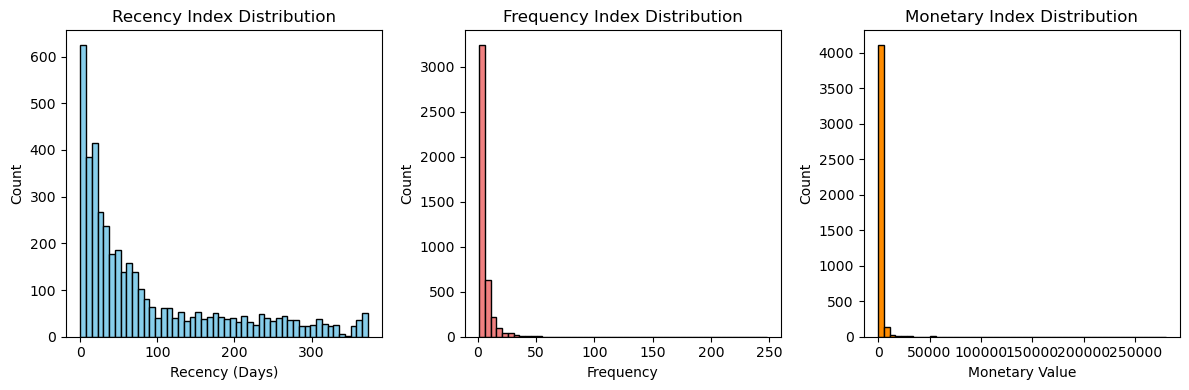

In [20]:
# Plot histograms for raw RFM values
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(rfm_df["Recency"], bins=50, color = "skyblue", edgecolor="black")
plt.xlabel("Recency (Days)")
plt.ylabel("Count")
plt.title("Recency Index Distribution")

plt.subplot(1, 3, 2)
plt.hist(rfm_df["Frequency"], bins=50, color = "lightcoral", edgecolor="black")
plt.xlabel("Frequency")
plt.ylabel("Count")
plt.title("Frequency Index Distribution")

plt.subplot(1, 3, 3)
plt.hist(rfm_df["Monetary"], bins=50, color = "darkorange", edgecolor="black")
plt.xlabel("Monetary Value")
plt.ylabel("Count")
plt.title("Monetary Index Distribution")

# Display histograms
plt.tight_layout()
plt.show()

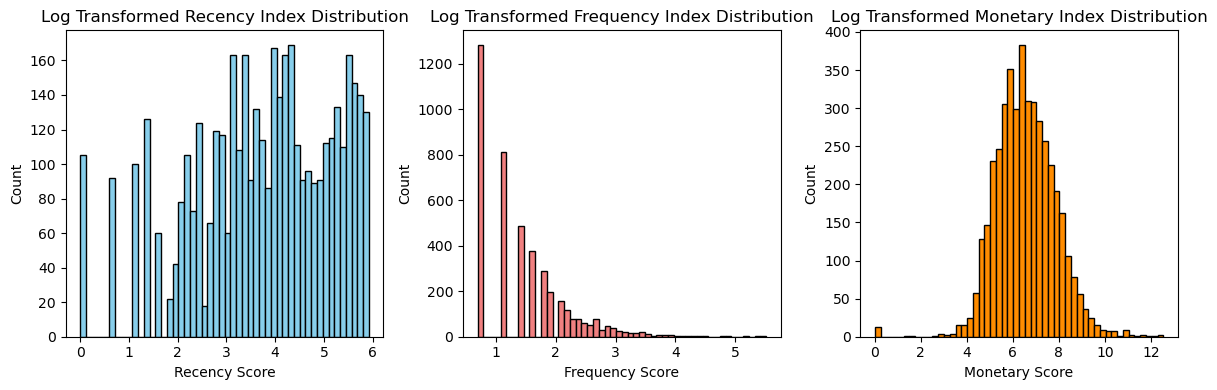

In [21]:
# Plot histograms for log transformed RFM values
plt.figure(figsize=(12, 4))

rfm_df["Log_Recency"] = np.log1p(rfm_df["Recency"])
rfm_df["Log_Frequency"] = np.log1p(rfm_df["Frequency"])
rfm_df["Log_Monetary"] = np.log1p(rfm_df["Monetary"])

plt.subplot(1, 3, 1)
plt.hist(rfm_df["Log_Recency"], bins=50, color = "skyblue", edgecolor="black")
plt.xlabel("Recency Score")
plt.ylabel("Count")
plt.title("Log Transformed Recency Index Distribution")

plt.subplot(1, 3, 2)
plt.hist(rfm_df["Log_Frequency"], bins=50, color = "lightcoral", edgecolor="black")
plt.xlabel("Frequency Score")
plt.ylabel("Count")
plt.title("Log Transformed Frequency Index Distribution")

plt.subplot(1, 3, 3)
plt.hist(rfm_df["Log_Monetary"], bins=50, color = "darkorange", edgecolor="black")
plt.xlabel("Monetary Score")
plt.ylabel("Count")
plt.title("Log Transformed Monetary Index Distribution")

# Display histograms
plt.tight_layout()
plt.show()

In [22]:
# Calculate the CAI index

cai_df = df
cai_df = df.sort_values(by=["CustomerID", "InvoiceDate"])

# Compute inter-purchase intervals (days between purchases)
cai_df["Interval"] = cai_df.groupby("CustomerID")["InvoiceDate"].diff().dt.days

# Assign increasing weights (starting from 1)
cai_df["Weight"] = cai_df.groupby("CustomerID").cumcount() + 1

# Compute weighted product of interval and weight
cai_df["Product"] = cai_df["Interval"] * cai_df["Weight"]

# Aggregate CAI components at the customer level
cai_df = cai_df.groupby("CustomerID").agg(
    Average_Interval=("Interval", "mean"),  # Step 1: Calculate average interval
    Sum_Weight=("Weight", "sum"),  # Step 2: Sum of weights
    Sum_Product=("Product", "sum")  # Step 3: Sum of weighted products
).reset_index()

# Step 4: Compute WMLE (Weighted Mean Logarithmic Expectation)
cai_df["WMLE"] = cai_df["Sum_Product"] / cai_df["Sum_Weight"]

# Compute CAI as the percentage change from WMLE
cai_df["CAI"] = ((cai_df["Average_Interval"] - cai_df["WMLE"]) / cai_df["WMLE"]) * 100
cai_df["CAI"] = cai_df["CAI"].replace([np.inf, -np.inf], np.nan).fillna(0)


# Merge CAI values back to the original dataframe
rfm_df = rfm_df.merge(cai_df[["CustomerID", "CAI"]], on="CustomerID")

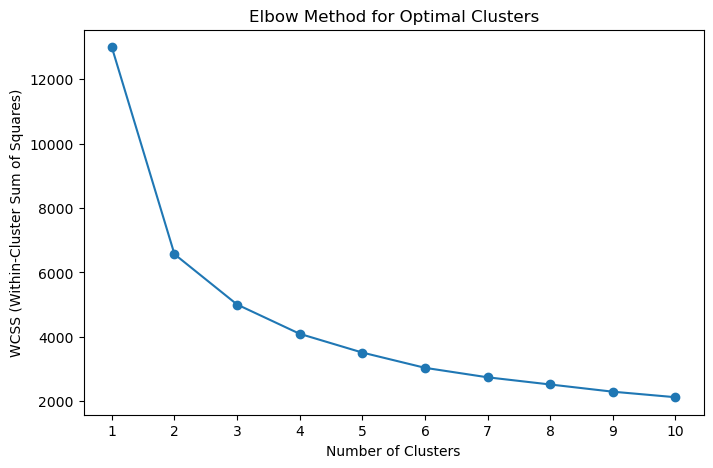

In [23]:
# Use the elbow method to search for optimal K

features = ["Log_Recency", "Log_Frequency", "Log_Monetary"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_df[features])

# Implementing the Elbow Method
wcss = []  
cluster_range = range(1, 11)  

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=14, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Store WCSS

# Plot the graph
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, wcss, marker="o", linestyle="-")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal Clusters")
plt.xticks(cluster_range)
plt.show()

In [24]:
# Applying with optimal K = 3

kmeans = KMeans(n_clusters=3, random_state=139)  
rfm_df["class"] = kmeans.fit_predict(X_scaled) + 1

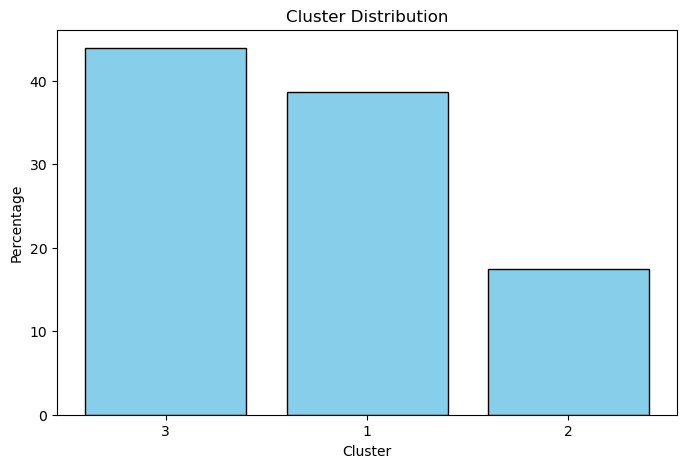

In [25]:
# Count the percentage of each cluster
cluster_counts = rfm_df["class"].value_counts(normalize=True) * 100

# Plot bar chart for cluster distribution
plt.figure(figsize=(8, 5))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Cluster")
plt.ylabel("Percentage")
plt.title("Cluster Distribution")
plt.show()

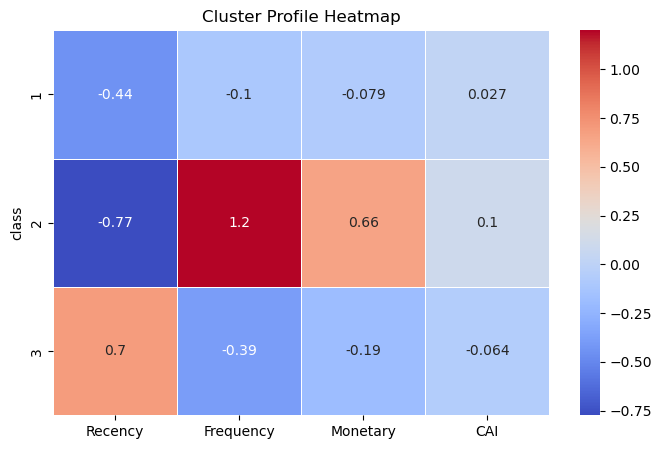

In [36]:
# Standardize RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary', 'CAI']])

# Convert back to DataFrame
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary', 'CAI'], index=rfm_df.index)

# Retain Cluster labels
rfm_scaled_df['class'] = rfm_df['class']

# Aggregate Mean Values per Cluster
heatmap_data = rfm_scaled_df.groupby('class').mean()

# Create Heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Cluster Profile Heatmap")
plt.show()

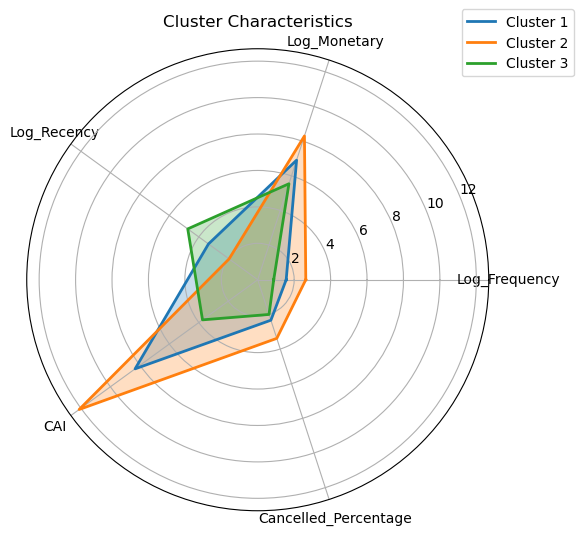

In [27]:
# Radar chart for each cluster 
cluster_means = rfm_df.groupby("class")[["Log_Frequency", "Log_Monetary", "Log_Recency", "CAI", "Cancelled_Percentage"]].mean()

labels = cluster_means.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

# Plot each cluster
for cluster in cluster_means.index:
    values = cluster_means.loc[cluster].tolist()
    values += values[:1]  # Close the radar chart
    ax.plot(angles + [angles[0]], values, label=f"Cluster {cluster}", linewidth=2)
    ax.fill(angles + [angles[0]], values, alpha=0.25)

ax.set_xticks(angles)
ax.set_xticklabels(labels)
ax.set_title("Cluster Characteristics")
ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()

In [377]:
# Merge class back to original df

df = df.merge(rfm_df[["CustomerID", "class"]], on="CustomerID", how="right") 
df["Transaction_Hour"] = df["InvoiceDate"].dt.hour

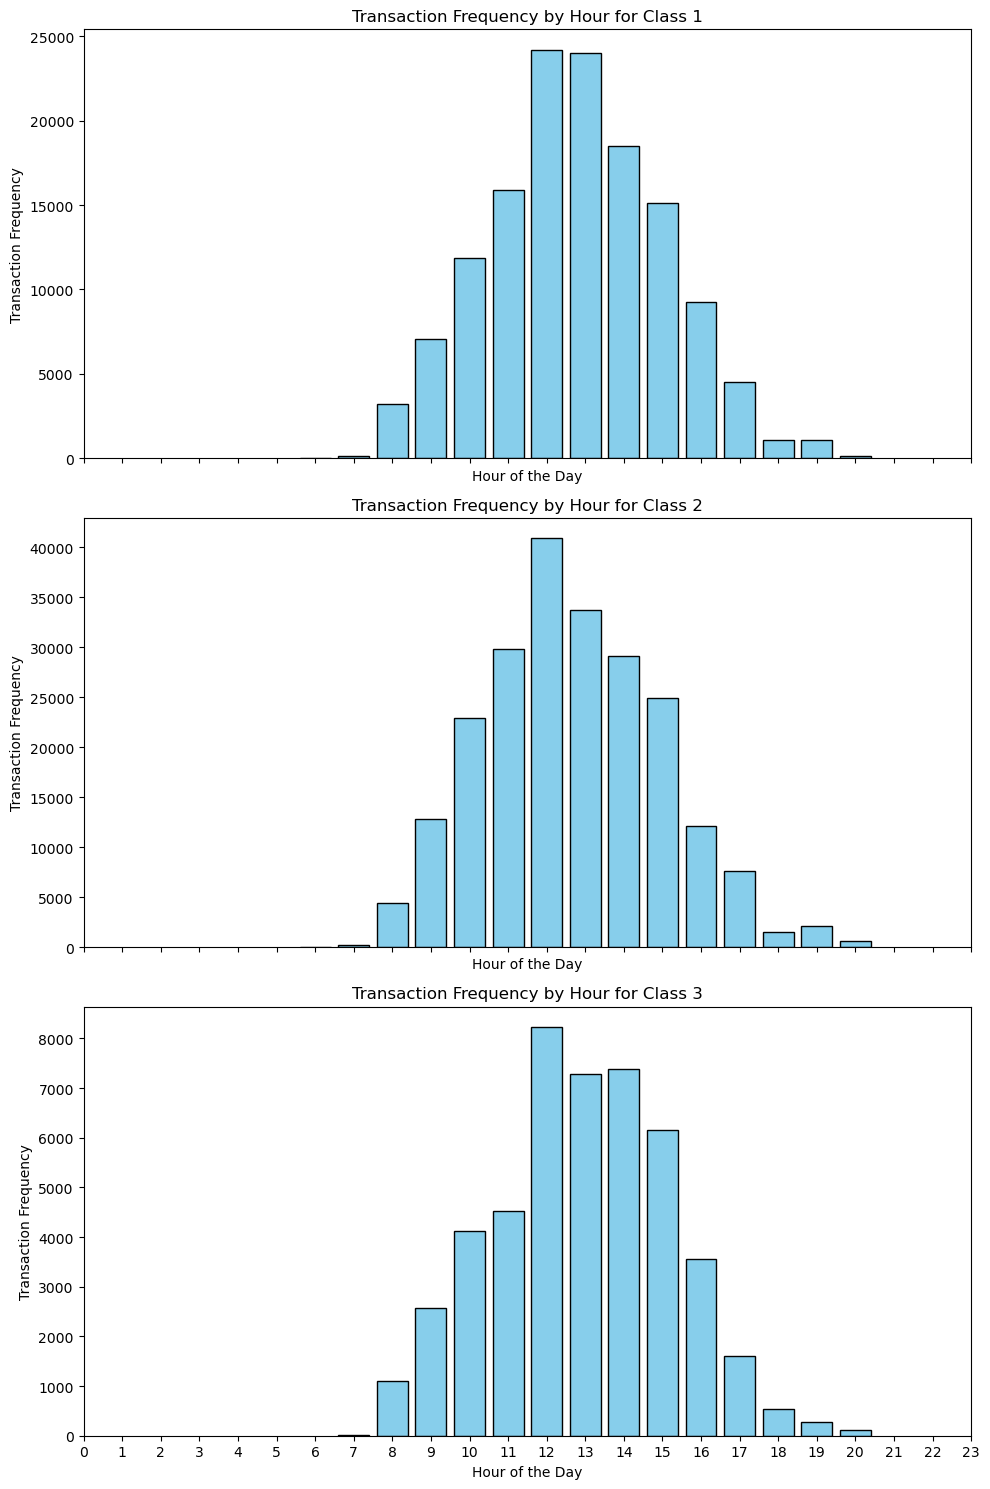

In [403]:
# PLot frequency to hour chart

unique_classes = df["class"].unique()
fig, axes = plt.subplots(len(unique_classes), 1, figsize=(10, 5 * len(unique_classes)), sharex=True)

# Plot transaction frequency per hour for each class
for i, class_label in enumerate(unique_classes[::-1]):
    class_df = df[df["class"] == class_label]  # Filter transactions for the class
    hourly_counts = class_df["Transaction_Hour"].value_counts().sort_index()  # Count transactions per hour

    # Bar plot
    axes[i].bar(hourly_counts.index, hourly_counts.values, color="skyblue", edgecolor="black")

    # Format x-axis (numbers 0-23 under every plot)
    axes[i].set_xticks(range(24))
    axes[i].set_xticklabels(range(24), fontsize=10)
    axes[i].set_ylabel("Transaction Frequency")
    axes[i].set_title(f"Transaction Frequency by Hour for Class {class_label}")
    axes[i].set_xlabel("Hour of the Day")  # Set x-label for every subplot

# Adjust layout to fit subplots properly
plt.tight_layout()
plt.show()

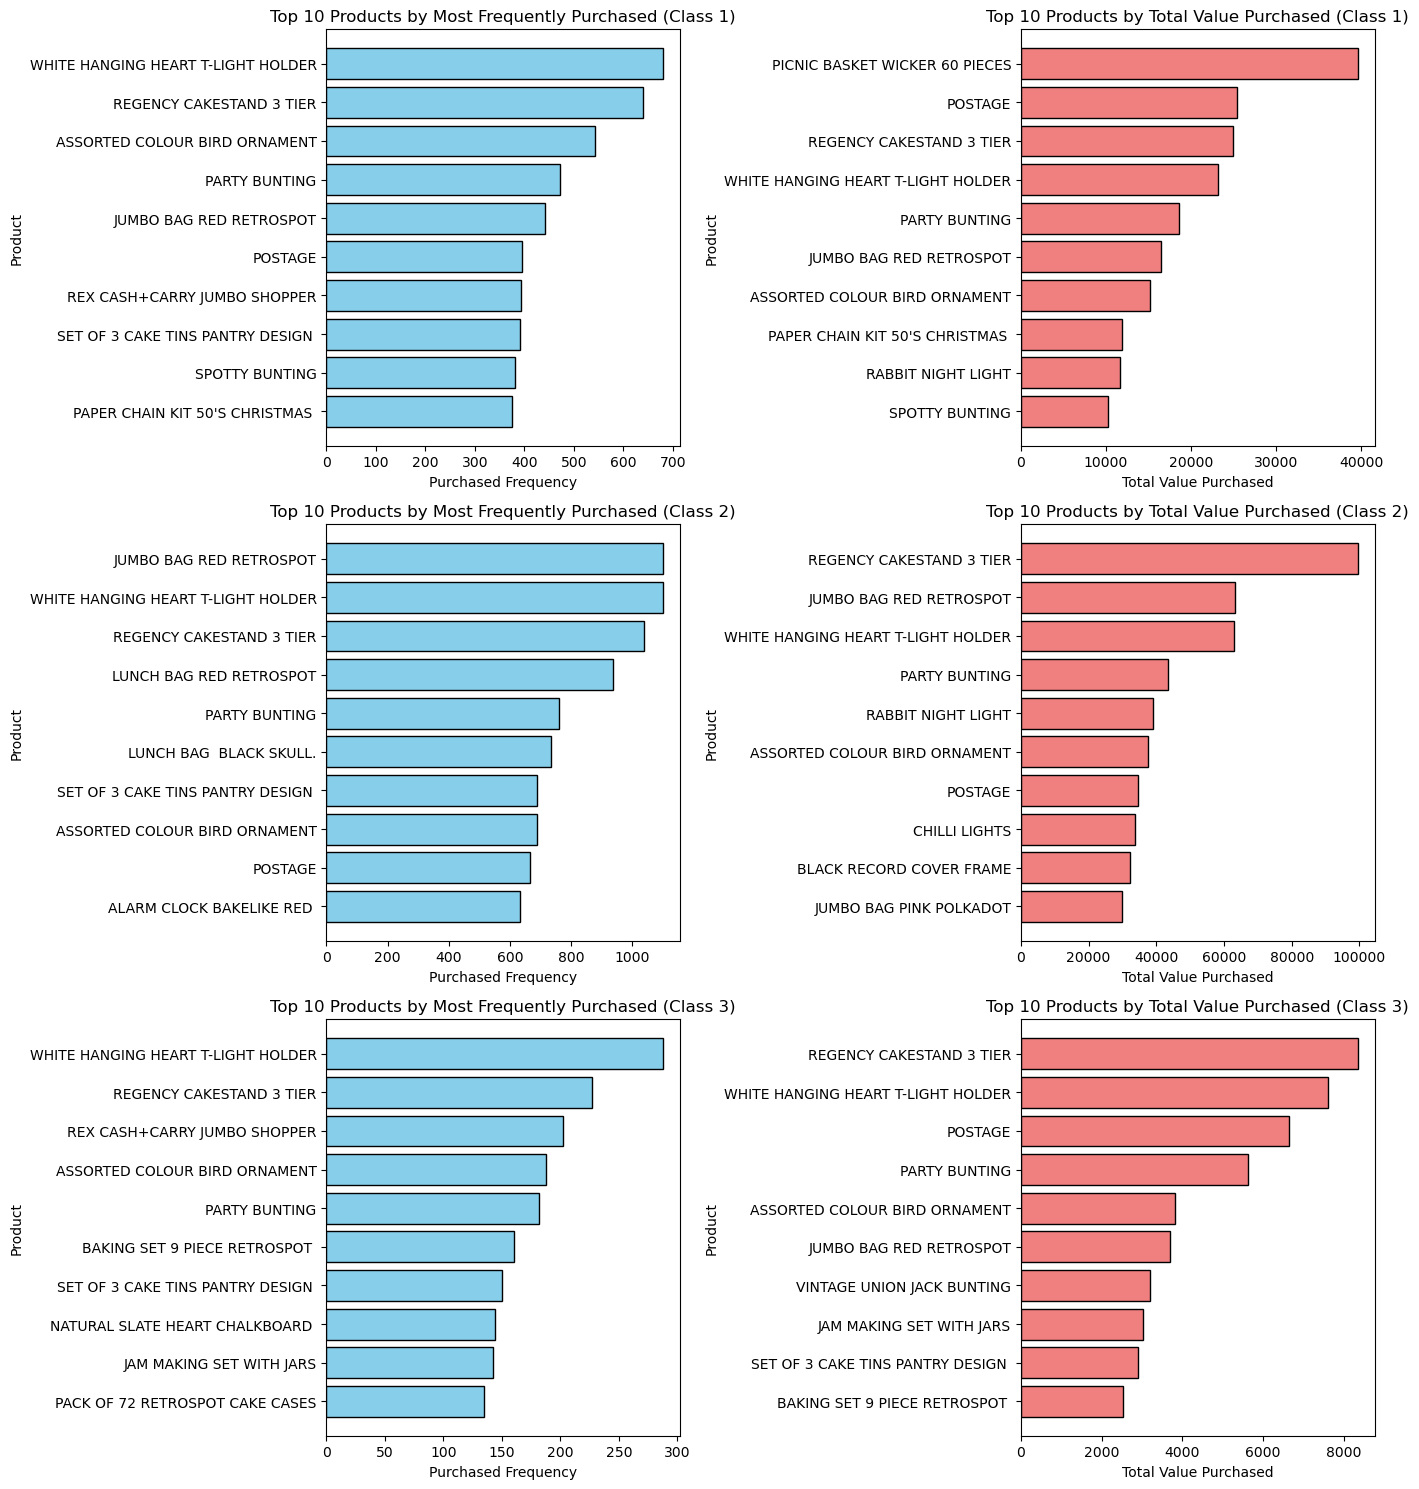

In [412]:
unique_classes = sorted(df["class"].unique())

# Set up the figure for multiple classes
fig, axes = plt.subplots(len(unique_classes), 2, figsize=(14, 5 * len(unique_classes)))

# Ensure axes is iterable when there's only one class
if len(unique_classes) == 1:
    axes = [axes]

# Plot for each class
for i, class_label in enumerate(unique_classes[::1]):
    class_df = df[df["class"] == class_label]  # Filter transactions for the class

    # Top 10 most purchased products
    top_products = class_df["Description"].value_counts().head(10)
    axes[i, 0].barh(top_products.index.astype(str), top_products.values, edgecolor='black', color='skyblue')
    axes[i, 0].set_xlabel("Purchased Frequency")
    axes[i, 0].set_ylabel("Product")
    axes[i, 0].set_title(f"Top 10 Products by Most Frequently Purchased (Class {class_label})")
    axes[i, 0].invert_yaxis()

    # Top 10 most purchased products based on total value purchased
    product_sales = class_df.groupby("Description")["Monetary"].sum()
    top_products_value = product_sales.nlargest(10)
    axes[i, 1].barh(top_products_value.index.astype(str), top_products_value.values, color='lightcoral', edgecolor='black')
    axes[i, 1].set_xlabel("Total Value Purchased")
    axes[i, 1].set_ylabel("Product")
    axes[i, 1].set_title(f"Top 10 Products by Total Value Purchased (Class {class_label})")
    axes[i, 1].invert_yaxis()

# Adjust layout to fit subplots properly
plt.tight_layout()
plt.show()